In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import plot, show, savefig, xlim, figure,  ylim, legend, boxplot, setp, axes

import copy

from sklearn.cluster import Birch
from sklearn import metrics
from sklearn.metrics import pairwise_distances

from sklearn import decomposition
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [2]:
df = pd.read_csv('../data.csv')
columns = list(df.columns)
df.shape

(288, 7)

In [3]:
def plot_silhouette_scores(model, test_data, n_clusters_min, n_clusters_max, title):
    """ Plot silhouette scores and return the best number of clusters"""

    if len(model.subcluster_labels_) >= 3:

        silhouette_scores = []

        clusters_range = range(3, n_clusters_max+1)
        results_dict = []
        # print(clusters_range)
        for number in clusters_range:
            # make a copy of the model so as not to mess up the 'correct' model
            model_cpy = copy.deepcopy(model)
            model_cpy.set_params(n_clusters=number)

            model_cpy.partial_fit()
            labels = model_cpy.predict(test_data)
            # print(labels)
            try: 
                s = metrics.silhouette_score(test_data, labels, metric='euclidean')
                silhouette_scores.append(s)
                results_dict.append((number, s))
            except ValueError:
                pass

        silhouette_range = [i[0] for i in results_dict]  
#         plt.plot(silhouette_range[:], silhouette_scores[:], label = title)
#         plt.xlabel('Number of Clusters')
#         plt.ylabel('Silhouette Score')
#         plt.title(title)
#         plt.legend(bbox_to_anchor=(0, 1), loc='upper left', ncol=1)
#         plt.savefig(folder + 'silhouette_'+ save_graph_name +'.png')
#         plt.show()
#         plt.close() 
        max_score = max(silhouette_scores)
#         print(results_dict)
        for i in results_dict:
            if i[1] == max_score:
#                 print("The highest silhouette scores(" + str(max_score) + ") is for " + str(i[0]) + " clusers")
                return int(i[0])
    else:
#         print('couldnt get the scores, plz help')
#         print('returning number of clusters = ' + str(n_clusters_min))
#         model_cpy = copy.deepcopy(model)
#         model_cpy.set_params(n_clusters=2)

#         model_cpy.partial_fit()
#         labels = model_cpy.predict(test_data)
#         s = metrics.silhouette_score(test_data, labels, metric='euclidean')
#         print(s)
#         print('\n')
        return n_clusters_min

In [4]:
def outliers_removal(df):
    data_split_modified_z = df[['median_overhead', 'q1_overhead', 'q3_overhead', 'p9_overhead', 'totalCarNumber', 'index']].copy()
    data_split_modified_z = data_split_modified_z.to_numpy()
    data_split_modified_z_12 = np.split(data_split_modified_z, 1)
    indexes = [] 

    for d in range(len(data_split_modified_z_12)):
        ind = []
        k = len(data_split_modified_z_12[d])
        for i in [0, 1, 2, 3]:
            ys = data_split_modified_z_12[d][:,i] 
            median_y = np.median(ys)
            median_absolute_deviation_y = np.median([np.abs(y - median_y) for y in ys])
    #         print(median_absolute_deviation_y)
            for y in range(len(data_split_modified_z_12[d])):
                modified_z_score = 0.6745 * (data_split_modified_z_12[d][y, i] - median_y) / median_absolute_deviation_y
    #             z_score = (data_split[d][y, i]  - mean_ys) / std_ys
                if np.abs(modified_z_score) > 3.5:
                    ind.append(y)


        data_split_modified_z_12[d] = np.delete(data_split_modified_z_12[d], ind, axis=0)
#         print('Outliers detected: ' + str((k - len(data_split_modified_z_12[d]))))

    data_split_modified_z_12 = np.concatenate(data_split_modified_z_12, axis=0)
    return data_split_modified_z_12

# the whole two days

In [5]:
# df=df.iloc[144:, :]
# indexes = np.array_split(df.index,8, axis=0)
# for i,index in enumerate(indexes):
#     df.loc[index,'group'] = i
    
# df['c'] = df['group'].diff()
# df_filtered = df[df['c'] != 0]

# index_list = df_filtered.index.tolist() # list of the start poisitions of index for change of values 
# print(len(index_list))
# print('\n')
# print(index_list)

# l_mod = index_list + [max(index_list)+1] # creating a list of indexes to iterate over (must have 0 in it)
# list_of_dfs = [df.iloc[l_mod[n]:l_mod[n+1]] for n in range(len(l_mod)-1)] # creating a list of dfs for each index

# len(list_of_dfs)

In [6]:
data_split_modified_z = df[['median_overhead', 'q1_overhead', 'q3_overhead', 'p9_overhead', 'totalCarNumber', 'index']].copy()
data_split_modified_z = data_split_modified_z.iloc[144:, :]
data_split_modified_z = data_split_modified_z.to_numpy()
# data_split_modified_z_12 = data_split_modified_z.to_numpy()


# """ SIZE 12 """
data_split_modified_z_12 = np.split(data_split_modified_z, 8)
indexes = [] 

for d in range(len(data_split_modified_z_12)):
    ind = []
    k = len(data_split_modified_z_12[d])
    for i in [0, 1, 2, 3]:
        ys = data_split_modified_z_12[d][:,i] 
        median_y = np.median(ys)
        median_absolute_deviation_y = np.median([np.abs(y - median_y) for y in ys])
        for y in range(len(data_split_modified_z_12[d])):
            modified_z_score = 0.6745 * (data_split_modified_z_12[d][y, i] - median_y) / median_absolute_deviation_y
            if np.abs(modified_z_score) > 3.5:
                ind.append(y)


    data_split_modified_z_12[d] = np.delete(data_split_modified_z_12[d], ind, axis=0)

# data_split_modified_z_12 = np.concatenate(data_split_modified_z_12, axis=0)

In [7]:
##########################################################
###############     THRESHOLD 0.01       #################
##########################################################


model_001_whole = Birch(n_clusters=None, threshold=0.01)
list_of_nmpys_for_graphs = []

removed_outliers_numpy = []
list_of_nmpys_for_graphs = []

labels_dict = {}

# add_data_to_this = pd.DataFrame(columns = columns)
for i in data_split_modified_z_12:
    numpy_array = i
    removed_outliers_numpy.append(numpy_array)
    model_001_whole.partial_fit(numpy_array[:, :-2])
    
new_nmpy = np.concatenate(removed_outliers_numpy, axis=0)
print('THRESHOLD 0.01')
n = plot_silhouette_scores(model_001_whole, new_nmpy[:, :-2], 2, 10, 'threshold 0.2')
model_001_whole.set_params(n_clusters = n)
model_001_whole.partial_fit()
print('\n')

lablels_001 = model_001_whole.predict(new_nmpy[:, :-2])

##########################################################
###############     THRESHOLD 0.05      #################
##########################################################


model_005_whole = Birch(n_clusters=None, threshold=0.05)
list_of_nmpys_for_graphs = []

removed_outliers_numpy = []
list_of_nmpys_for_graphs = []

labels_dict = {}

# add_data_to_this = pd.DataFrame(columns = columns)
for i in data_split_modified_z_12:
    numpy_array = i
    removed_outliers_numpy.append(numpy_array)
    model_005_whole.partial_fit(numpy_array[:, :-2])
    
new_nmpy = np.concatenate(removed_outliers_numpy, axis=0)
print('THRESHOLD 0.05')
n = plot_silhouette_scores(model_005_whole, new_nmpy[:, :-2], 2, 10, 'threshold 0.2')
model_005_whole.set_params(n_clusters = n)
model_005_whole.partial_fit()
print('\n')
lablels_005 = model_005_whole.predict(new_nmpy[:, :-2])

##########################################################
###############     THRESHOLD 0.1       #################
##########################################################


model_01_whole = Birch(n_clusters=None, threshold=0.1)
list_of_nmpys_for_graphs = []

removed_outliers_numpy = []
list_of_nmpys_for_graphs = []

labels_dict = {}

# add_data_to_this = pd.DataFrame(columns = columns)
for i in data_split_modified_z_12:
    numpy_array = i
    removed_outliers_numpy.append(numpy_array)
    model_01_whole.partial_fit(numpy_array[:, :-2])
    
new_nmpy = np.concatenate(removed_outliers_numpy, axis=0)
print('THRESHOLD 0.1')
n = plot_silhouette_scores(model_01_whole, new_nmpy[:, :-2], 2, 10, 'threshold 0.2')
model_01_whole.set_params(n_clusters = n)
model_01_whole.partial_fit()
print('\n')

lablels_01 = model_01_whole.predict(new_nmpy[:, :-2])


##########################################################
###############     THRESHOLD 0.2       #################
##########################################################


model_02_whole = Birch(n_clusters=None, threshold=0.2)
list_of_nmpys_for_graphs = []

removed_outliers_numpy = []
list_of_nmpys_for_graphs = []

labels_dict = {}

# add_data_to_this = pd.DataFrame(columns = columns)
for i in data_split_modified_z_12:
    numpy_array = i
    removed_outliers_numpy.append(numpy_array)
    model_02_whole.partial_fit(numpy_array[:, :-2])
    
new_nmpy = np.concatenate(removed_outliers_numpy, axis=0)
print('THRESHOLD 0.2')
n = plot_silhouette_scores(model_02_whole, new_nmpy[:, :-2], 2, 10, 'threshold 0.2')
model_02_whole.set_params(n_clusters = n)
model_02_whole.partial_fit()
print('\n')

lablels_02 = model_02_whole.predict(new_nmpy[:, :-2])


##########################################################
###############     THRESHOLD 0.3      #################
##########################################################



model_03_whole = Birch(n_clusters=None, threshold=0.3)
list_of_nmpys_for_graphs = []

removed_outliers_numpy = []
list_of_nmpys_for_graphs = []

labels_dict = {}

# add_data_to_this = pd.DataFrame(columns = columns)
for i in data_split_modified_z_12:
    numpy_array = i
    removed_outliers_numpy.append(numpy_array)
    model_03_whole.partial_fit(numpy_array[:, :-2])
    
new_nmpy = np.concatenate(removed_outliers_numpy, axis=0)
print('THRESHOLD 0.3')
n = plot_silhouette_scores(model_03_whole, new_nmpy[:, :-2], 2, 10, 'threshold 0.3')
model_03_whole.set_params(n_clusters = n)
model_03_whole.partial_fit()
print('\n')

lablels_03 = model_03_whole.predict(new_nmpy[:, :-2])

##########################################################
###############     THRESHOLD 0.5      #################
##########################################################

model_05_whole = Birch(n_clusters=None, threshold=0.5)
list_of_nmpys_for_graphs = []

removed_outliers_numpy = []
list_of_nmpys_for_graphs = []

labels_dict = {}

# add_data_to_this = pd.DataFrame(columns = columns)
for i in data_split_modified_z_12:
    numpy_array = i
    removed_outliers_numpy.append(numpy_array)
    model_05_whole.partial_fit(numpy_array[:, :-2])
    
print('THRESHOLD 0.5')
new_nmpy = np.concatenate(removed_outliers_numpy, axis=0)
n = plot_silhouette_scores(model_05_whole, new_nmpy[:, :-2], 2, 10, 'threshold 0.5')
model_05_whole.set_params(n_clusters = n)
model_05_whole.partial_fit()
print('\n')

lablels_05 = model_05_whole.predict(new_nmpy[:, :-2])

THRESHOLD 0.01


THRESHOLD 0.05


THRESHOLD 0.1


THRESHOLD 0.2


THRESHOLD 0.3


THRESHOLD 0.5




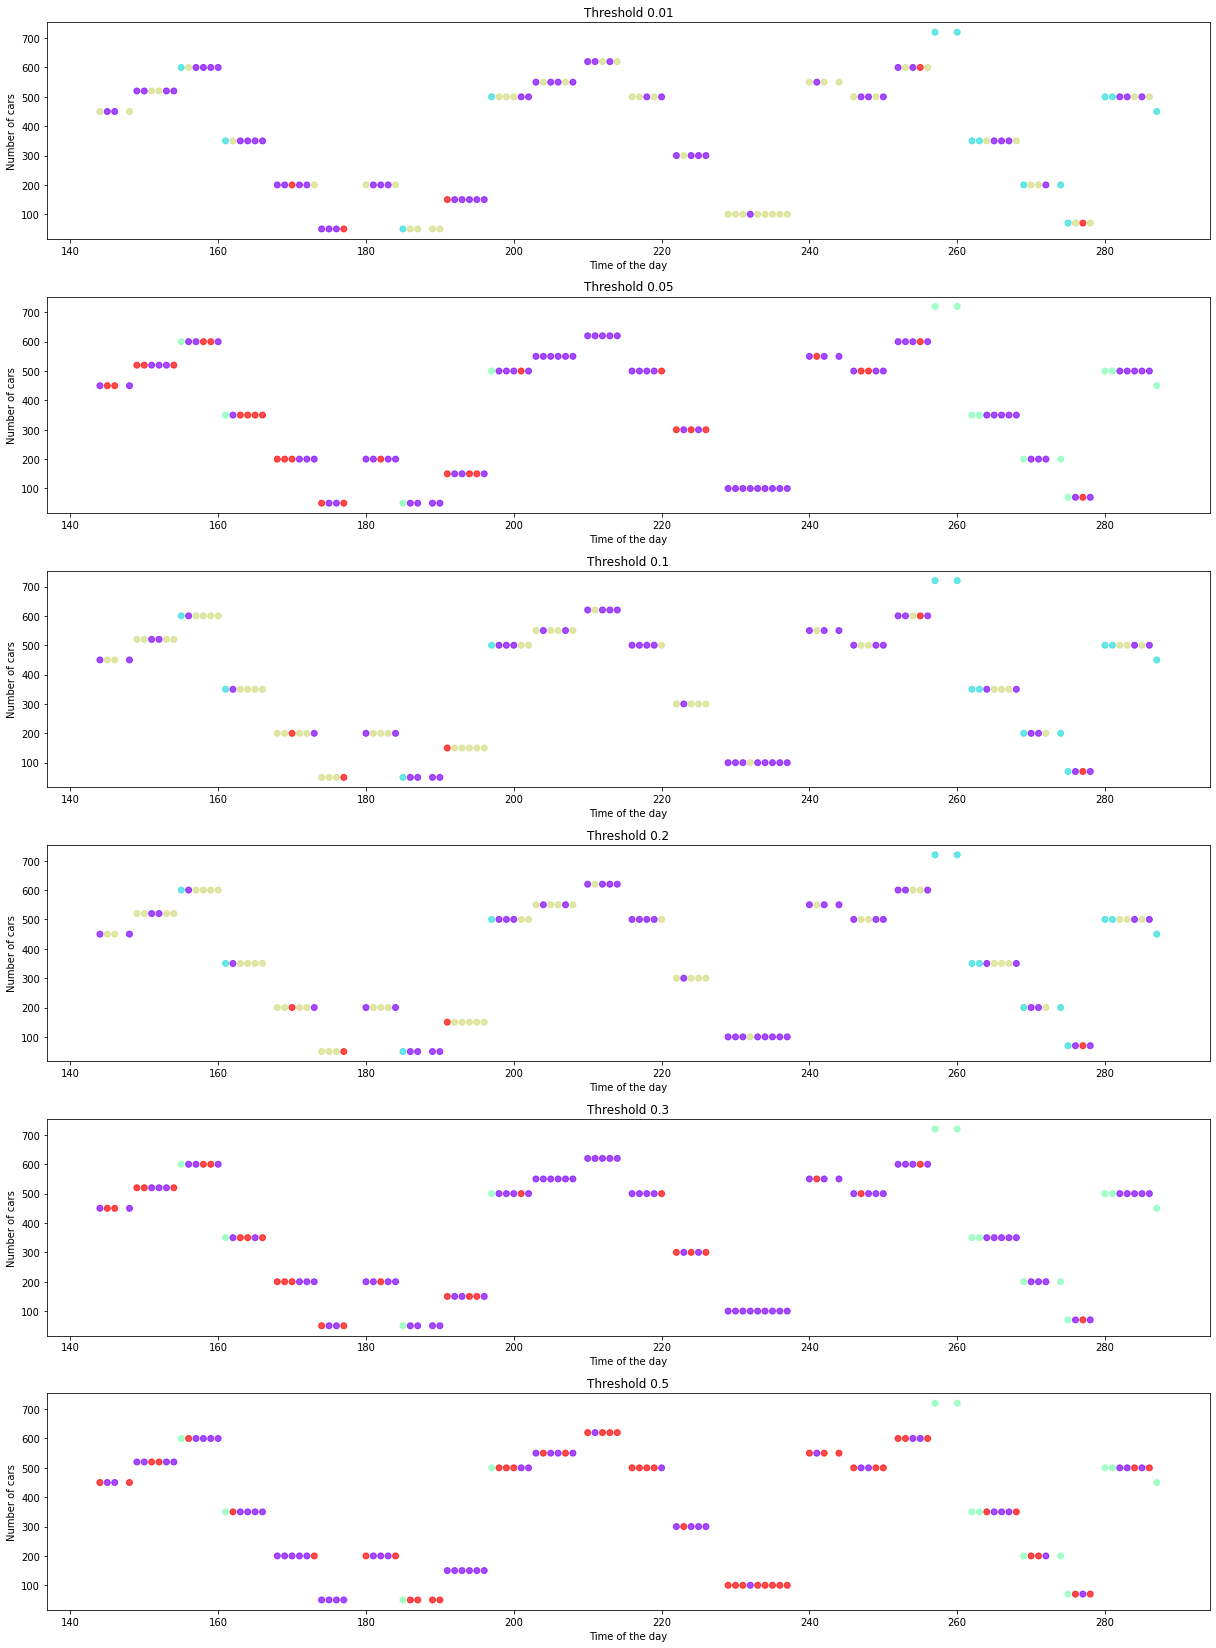

In [8]:
figure, axs = plt.subplots(nrows=6, ncols=1,figsize=(17,25))

axs[0].scatter(new_nmpy[:,5], new_nmpy[:,4], c=lablels_001, cmap='rainbow', alpha=0.7)
# axs[0].axvline(x=143, color='g')
axs[0].set_ylabel('Number of cars')
axs[0].set_xlabel('Time of the day')
axs[0].title.set_text("Threshold 0.01")

axs[1].scatter(new_nmpy[:,5], new_nmpy[:,4], c=lablels_005, cmap='rainbow', alpha=0.7)
# axs[1].axvline(x=143, color='g')
axs[1].set_ylabel('Number of cars')
axs[1].set_xlabel('Time of the day')
axs[1].title.set_text("Threshold 0.05")

axs[2].scatter(new_nmpy[:,5], new_nmpy[:,4], c=lablels_01, cmap='rainbow', alpha=0.7) 
# axs[2].axvline(x=143, color='g')
axs[2].set_ylabel('Number of cars')
axs[2].set_xlabel('Time of the day')
axs[2].title.set_text("Threshold 0.1")

axs[3].scatter(new_nmpy[:,5], new_nmpy[:,4], c=lablels_02, cmap='rainbow', alpha=0.7)  
# axs[3].axvline(x=143, color='g')
axs[3].set_ylabel('Number of cars')
axs[3].set_xlabel('Time of the day')
axs[3].title.set_text("Threshold 0.2")

axs[4].scatter(new_nmpy[:,5], new_nmpy[:,4], c=lablels_03, cmap='rainbow', alpha=0.7)
# axs[4].axvline(x=143, color='g')
axs[4].set_ylabel('Number of cars')
axs[4].set_xlabel('Time of the day')
axs[4].title.set_text("Threshold 0.3")

axs[5].scatter(new_nmpy[:,5], new_nmpy[:,4], c=lablels_05, cmap='rainbow', alpha=0.7)
# axs[5].axvline(x=143, color='g')
axs[5].set_ylabel('Number of cars')
axs[5].set_xlabel('Time of the day')
axs[5].title.set_text("Threshold 0.5")

figure.tight_layout(rect=[0, 0.03, 1, 0.95])

# pick threshold with best score and depict a run of it

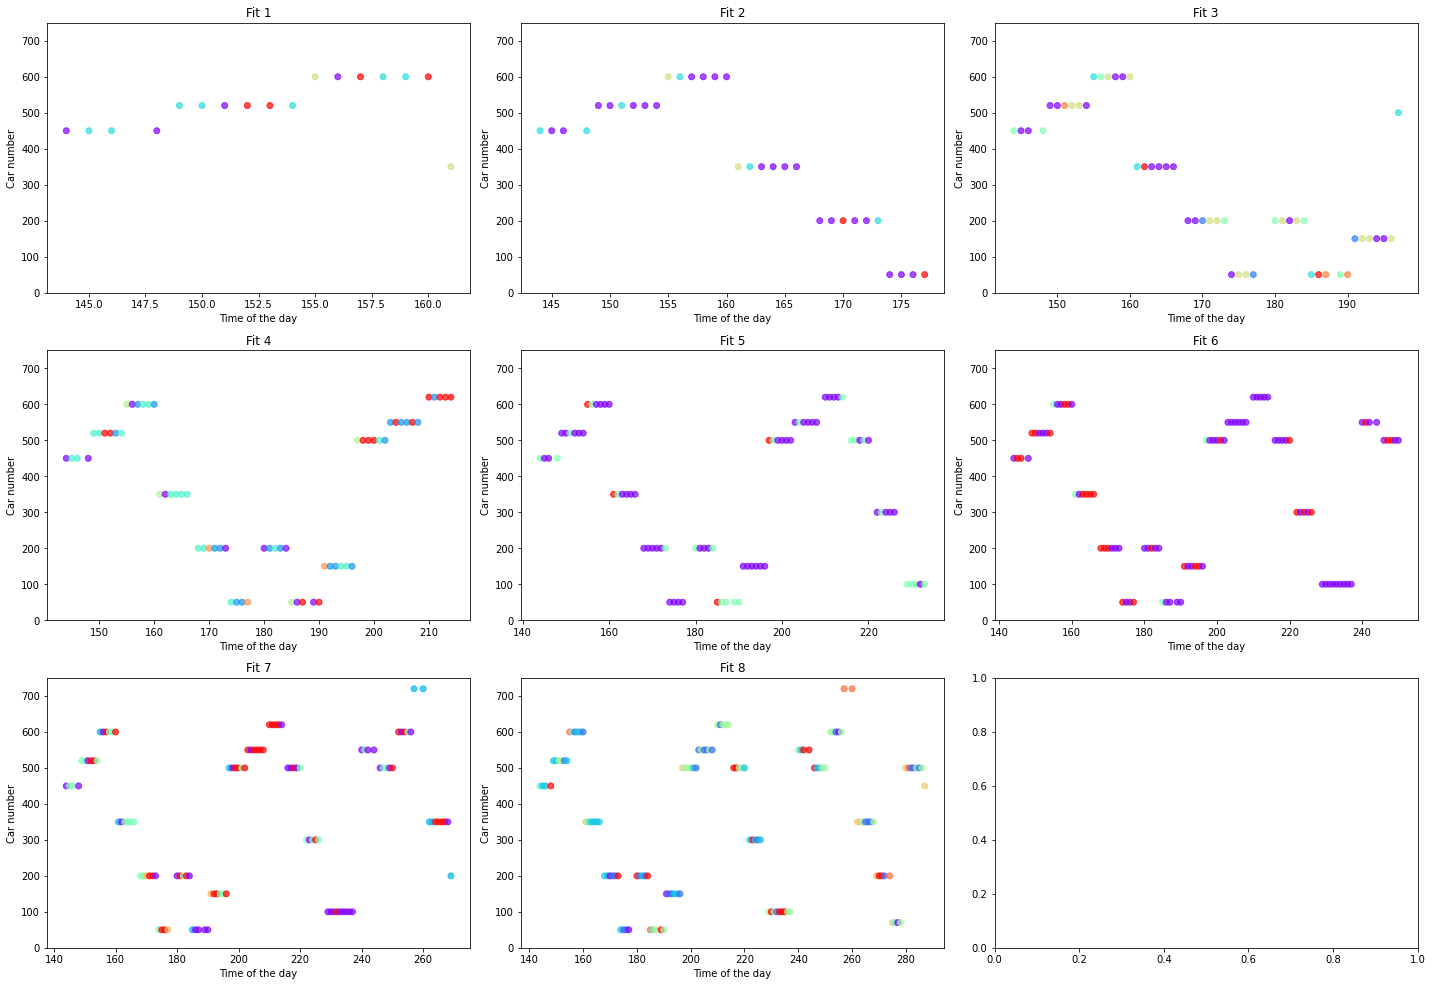

In [9]:
model_03_before= Birch(n_clusters=None, threshold=0.1)

list_of_nmpys_for_graphs = []

removed_outliers_numpy = []
list_of_nmpys_for_graphs = []

labels_dict = {}
add_data_to_this = pd.DataFrame(columns = columns)

fit_number = 1

for i in data_split_modified_z_12:

    numpy_array = i
    model_03_before.partial_fit(numpy_array[:, :-2])
    
    model_copy = copy.deepcopy(model_03_before)
    
    removed_outliers_numpy.append(numpy_array)
    new_nmpy = np.concatenate(removed_outliers_numpy, axis=0)
    
    n = plot_silhouette_scores(model_copy, numpy_array[:, :-2], 2, 10, 'threshold 0.05')
    
    model_copy.set_params(n_clusters = n)
    model_copy.partial_fit()
    
    labels_dict[f'fit_{fit_number}'] = model_copy.predict(new_nmpy[:, :-2])
    
    list_of_nmpys_for_graphs.append(new_nmpy)
    fit_number += 1

    
    
col_counter = 0
row_counter = 0

fit_number = 1

nrows = 3
ncols = 3

figure, axs = plt.subplots(nrows=nrows, ncols=ncols,figsize=(20,15))

for i in list_of_nmpys_for_graphs:
    
#     numpy_array = i.to_numpy()
    
    figure.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    axs[row_counter,col_counter].scatter(i[:, 5], i[:, 4], c =labels_dict[f'fit_{fit_number}'], cmap='rainbow', alpha=0.7 )
    axs[row_counter,col_counter].set_xlabel('Time of the day')
    axs[row_counter,col_counter].set_ylim(0, 750)
    axs[row_counter,col_counter].set_ylabel('Car number')
    axs[row_counter,col_counter].set_title(f'Fit {fit_number}')
    
    if fit_number >= 9:
        axs[row_counter,col_counter].axvline(x=143, color='g')
        
    if col_counter == (ncols-1):
        col_counter = 0
        row_counter += 1
    else:
        col_counter += 1
    
#     print(f'{col_counter}, {row_counter}')
    
    fit_number += 1
    
# fit_number = 1
# outlier_dict = {}

# for k in labels_dict:
# #     print(k)
#     arr = labels_dict[k]
# #     print(arr)
#     fit =  np.array_split(arr, 3*fit_number)
#     outlier_counter = 0

#     for value in fit: # value is each of the 6 points
# #         print(value)
#         ilosc = len(value)

#         coun = np.array(np.unique(value, return_counts=True)).T
#         for num in coun:
#     #   print(coun)
#             p = (num[1]*100)/ilosc
#             if p < 50:
#                 outlier_counter += num[1]

        
#     outlier_dict[k] = outlier_counter

#     fit_number += 1 


# for i in outlier_dict:
#     print(outlier_dict[i])